In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, log_loss
import warnings
warnings.filterwarnings('ignore')

## <u>Milestone 1</u>

### Description

The goal of this project will be to use data to predict NBA all-stars. This work contains a few years (2017-2019) of historical player data. I believe an additional direction this could be taken to incorporate more of this course's material would be to perform sentiment analysis on Twitter posts that mention players as well.

### Load Data into a DataFrame

In [2]:
path = r'D:\School\550\Data\Final'  # Filepath
fileList = glob.glob(path + "/*.csv")
dfList = []

for f in fileList:  # Read each csv from the file list into a DataFrame, and then append that DataFrame to a list.
    df1 = pd.read_csv(f,encoding='latin1')
    dfList.append(df1)

df = pd.concat(dfList, axis=0, ignore_index=True)  # Concatenate DataFrames for each year.
df['AllStar'] = df.AllStar.astype(str)
df = df[df.GS >= 41]  # Filter data to players who started at least half the season.

df

,Rk,Player,Year,AllStar,Pos,Age,Tm,G,GS,MP,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
4,3,Steven Adams\adamsst01,2017,0,C,23,OKC,80,80,29.9,...,0.611,3.5,4.2,7.7,1.1,1.1,1.0,1.8,2.4,11.3
5,4,Arron Afflalo\afflaar01,2017,0,SG,31,SAC,61,45,25.9,...,0.892,0.1,1.9,2.0,1.3,0.3,0.1,0.7,1.7,8.4
8,7,LaMarcus Aldridge\aldrila01,2017,0,PF,31,SAS,72,72,32.4,...,0.812,2.4,4.9,7.3,1.9,0.6,1.2,1.4,2.2,17.3
10,9,Tony Allen\allento01,2017,0,SG,35,MEM,71,66,27.0,...,0.615,2.3,3.2,5.5,1.4,1.6,0.4,1.4,2.5,9.1
18,15,Ryan Anderson\anderry01,2017,0,PF,28,HOU,72,72,29.4,...,0.860,1.6,3.0,4.6,0.9,0.4,0.2,0.8,2.0,13.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,516,Marvin Williams\willima02,2019,0,PF,32,CHO,75,75,28.4,...,0.767,1.0,4.4,5.4,1.2,0.9,0.8,0.6,2.1,10.1
1948,520,Justise Winslow\winslju01,2019,0,SF,22,MIA,66,52,29.7,...,0.628,1.0,4.4,5.4,4.3,1.1,0.3,2.2,2.7,12.6
1957,525,Thaddeus Young\youngth01,2019,0,PF,30,IND,81,81,30.7,...,0.644,2.4,4.1,6.5,2.5,1.5,0.4,1.5,2.4,12.6
1958,526,Trae Young\youngtr01,2019,0,PG,20,ATL,81,81,30.9,...,0.829,0.8,2.9,3.7,8.1,0.9,0.2,3.8,1.7,19.1


### Variables in the Table

In [3]:
print("Describe Data")
print(df.describe())

Describe Data
               Rk         Year         Age           G          GS  \
count  441.000000   441.000000  441.000000  441.000000  441.000000   
mean   243.759637  2018.018141   26.557823   70.269841   65.594104   
std    150.387413     0.819998    3.942996   10.355158   12.423067   
min      3.000000  2017.000000   19.000000   41.000000   41.000000   
25%    114.000000  2017.000000   24.000000   64.000000   55.000000   
50%    223.000000  2018.000000   27.000000   73.000000   68.000000   
75%    373.000000  2019.000000   29.000000   79.000000   77.000000   
max    535.000000  2019.000000   39.000000   82.000000   82.000000   

               MP          FG         FGA         FG%          3P  ...  \
count  441.000000  441.000000  441.000000  441.000000  441.000000  ...   
mean    30.082993    5.542857   11.856689    0.470029    1.374830  ...   
std      4.194548    1.968952    4.146757    0.058336    0.927963  ...   
min     14.100000    1.700000    3.600000    0.360000    0.

### Histograms

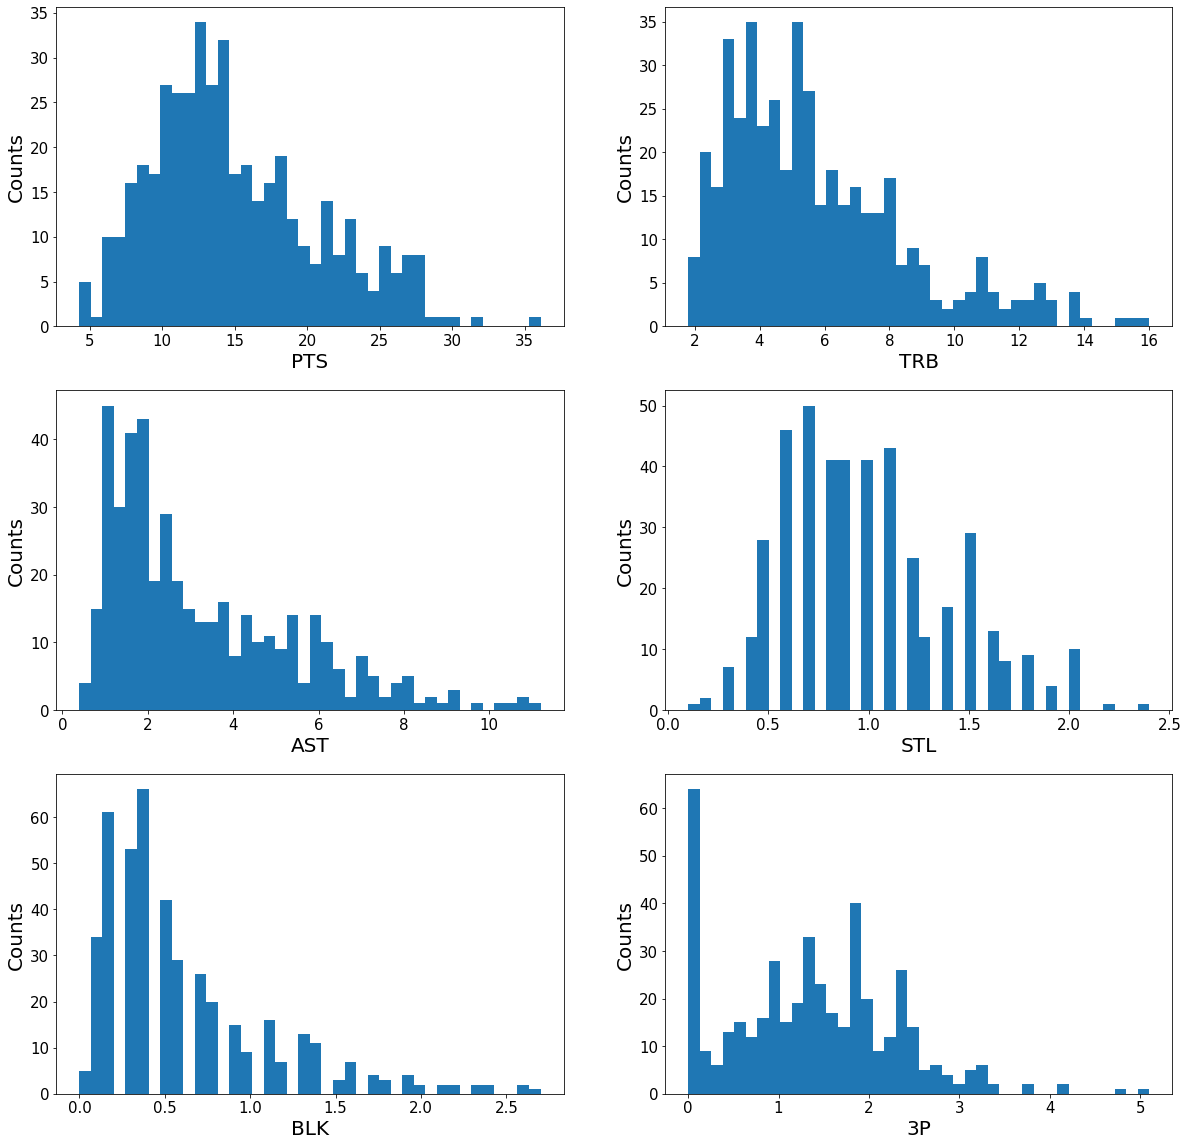

In [4]:
# Histograms to look at the overall distribution of some key features.

plt.rcParams['figure.figsize'] = (20, 20)
fig, axes = plt.subplots(nrows = 3, ncols = 2)

# Specify the features of interest
num_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK', '3P']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts', 'Counts', 'Counts', 'Counts']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(df[num_features[idx]].dropna(), bins=40)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=15)

### Scatter Plots

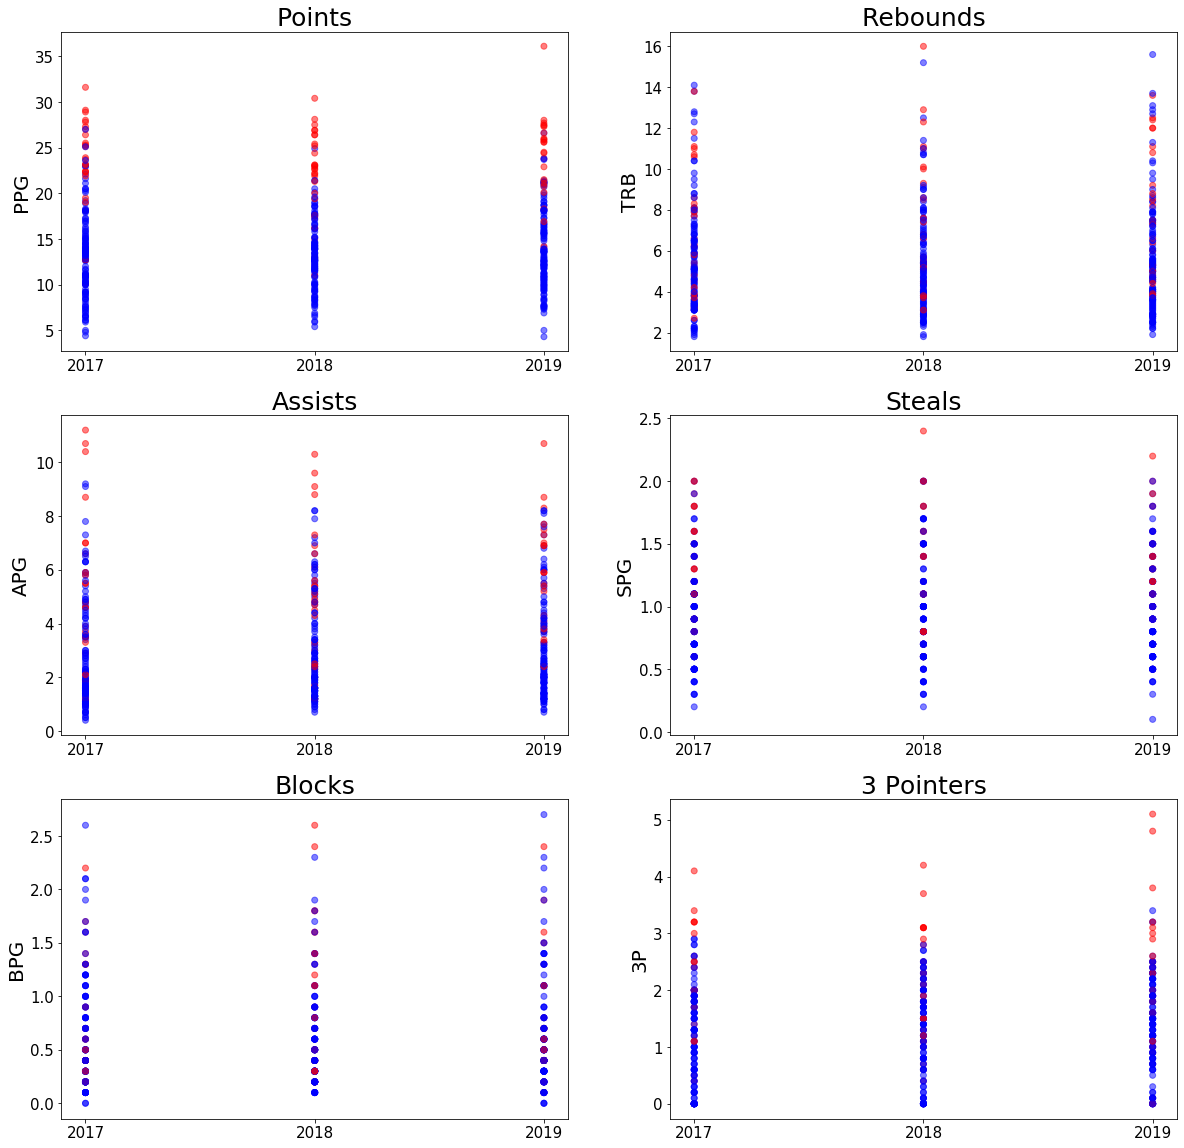

In [5]:
# Scatter plots to look at where the all-stars compare to the rest of the players by year.

plt.rcParams['figure.figsize'] = (20, 20)

# make subplots
fig, axes = plt.subplots(nrows = 3, ncols = 2)

# color mapping
colors = {'1':'red', '0':'blue'}

# PTS scatter plot
axes[0, 0].scatter(df.Year, df.PTS, c=df.AllStar.apply(lambda x: colors[x]), alpha=0.5)
axes[0, 0].set_title('Points', fontsize=25)
axes[0, 0].set_ylabel('PPG', fontsize=20)
axes[0, 0].set_xticks([2017,2018,2019])
axes[0, 0].set_xticklabels(['2017','2018','2019'])
axes[0, 0].tick_params(axis='both', labelsize=15)

# TRB scatter plot
axes[0, 1].scatter(df.Year, df.TRB, c=df.AllStar.apply(lambda x: colors[x]), alpha=0.5)
axes[0, 1].set_title('Rebounds', fontsize=25)
axes[0, 1].set_ylabel('TRB', fontsize=20)
axes[0, 1].set_xticks([2017,2018,2019])
axes[0, 1].set_xticklabels(['2017','2018','2019'])
axes[0, 1].tick_params(axis='both', labelsize=15)

# AST scatter plot
axes[1, 0].scatter(df.Year, df.AST, c=df.AllStar.apply(lambda x: colors[x]), alpha=0.5)
axes[1, 0].set_title('Assists', fontsize=25)
axes[1, 0].set_ylabel('APG', fontsize=20)
axes[1, 0].set_xticks([2017,2018,2019])
axes[1, 0].set_xticklabels(['2017','2018','2019'])
axes[1, 0].tick_params(axis='both', labelsize=15)

# STL scatter plot
axes[1, 1].scatter(df.Year, df.STL, c=df.AllStar.apply(lambda x: colors[x]), alpha=0.5)
axes[1, 1].set_title('Steals', fontsize=25)
axes[1, 1].set_ylabel('SPG', fontsize=20)
axes[1, 1].set_xticks([2017,2018,2019])
axes[1, 1].set_xticklabels(['2017','2018','2019'])
axes[1, 1].tick_params(axis='both', labelsize=15)

# BLK scatter plot
axes[2, 0].scatter(df.Year, df.BLK, c=df.AllStar.apply(lambda x: colors[x]), alpha=0.5)
axes[2, 0].set_title('Blocks', fontsize=25)
axes[2, 0].set_ylabel('BPG', fontsize=20)
axes[2, 0].set_xticks([2017,2018,2019])
axes[2, 0].set_xticklabels(['2017','2018','2019'])
axes[2, 0].tick_params(axis='both', labelsize=15)

# 3P scatter plot
axes[2, 1].scatter(df.Year, df['3P'], c=df.AllStar.apply(lambda x: colors[x]), alpha=0.5)
axes[2, 1].set_title('3 Pointers', fontsize=25)
axes[2, 1].set_ylabel('3P', fontsize=20)
axes[2, 1].set_xticks([2017,2018,2019])
axes[2, 1].set_xticklabels(['2017','2018','2019'])
axes[2, 1].tick_params(axis='both', labelsize=15)



### Pearson Ranking

array([[11.3,  7.7,  1.1,  1.1,  1. ,  0. ],
       [ 8.4,  2. ,  1.3,  0.3,  0.1,  1. ],
       [17.3,  7.3,  1.9,  0.6,  1.2,  0.3],
       ...,
       [12.6,  6.5,  2.5,  1.5,  0.4,  0.6],
       [19.1,  3.7,  8.1,  0.9,  0.2,  1.9],
       [10.1,  6.8,  2.1,  0.8,  0.8,  0.1]])

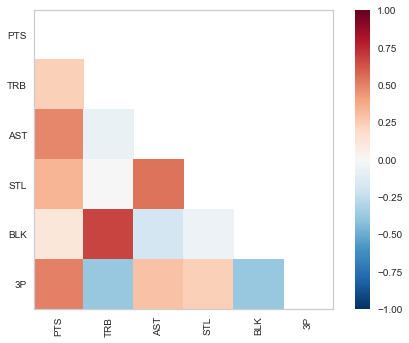

In [6]:
# Examine correlation of selected features. Rebounds and blocks seem to have the highest correlation out of these
# selected features.

plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X = df[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data


## <u>Milestone 2</u>

### Feature Elimination

In [7]:
df1 = df.drop(['Rk','Player','Year','Tm'], axis=1)  # These are accounting variables and indices that we do not want to include.

y_col = ['AllStar']  # Variable that we want to predict.
x_col = [i for i in df1 if i not in y_col]  # Independent variables.
x_col

['Pos',
 'Age',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS']

### Check Categorical Variable

In [8]:
print(df1['Pos'].value_counts(dropna=False))  # Examine values.
df1['Pos'] = [x.split('-')[0] for x in df['Pos']]  # Keep just the first value if there are multiple positions listed.
print(df1['Pos'].value_counts(dropna=False))  # Check values after the split.


SG       93
C        93
PG       91
PF       83
SF       78
SF-SG     2
PF-SF     1
Name: Pos, dtype: int64
SG    93
C     93
PG    91
PF    84
SF    80
Name: Pos, dtype: int64


### Variance Threshold

In [9]:
min_max = MinMaxScaler()  # MinMaxScaler.
scaled = min_max.fit_transform(df1.loc[:, df1.columns != 'Pos'])  # Apply min-max scaling to columns other than Position.
col = list(df1.columns)
col.remove('Pos')
df_scaled = pd.DataFrame(scaled, columns=col)  # Convert numpy array results to dataframe.

print(df_scaled.var())  # See the variance by column.
print(df_scaled.var() < 0.03) 
x_col = [x for x in x_col if x not in ['FG%','3P%','2P%','eFG%','TOV']]  # Remove those columns from our independent variables.
x_col

AllStar    0.144444
Age        0.038868
G          0.063789
GS         0.091810
MP         0.031324
FG         0.046815
FGA        0.039366
FG%        0.027156
3P         0.033107
3PA        0.032326
3P%        0.011405
2P         0.038916
2PA        0.035134
2P%        0.023400
eFG%       0.023995
FT         0.031283
FTA        0.035130
FT%        0.031862
ORB        0.032695
DRB        0.044241
TRB        0.038414
AST        0.041129
STL        0.031881
BLK        0.035821
TOV        0.025548
PF         0.034270
PTS        0.033069
dtype: float64
AllStar    False
Age        False
G          False
GS         False
MP         False
FG         False
FGA        False
FG%         True
3P         False
3PA        False
3P%         True
2P         False
2PA        False
2P%         True
eFG%        True
FT         False
FTA        False
FT%        False
ORB        False
DRB        False
TRB        False
AST        False
STL        False
BLK        False
TOV         True
PF         False
PTS

['Pos',
 'Age',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 '3P',
 '3PA',
 '2P',
 '2PA',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'PF',
 'PTS']

From your comment on milestone 2 about using a min-max scaling before applying variance threshold, this is resulting in a very low variance for every variable. 

### Dummy Variables

In [10]:
X = pd.get_dummies(df1[x_col])  # Creates columns for each of the five position values.
y = df1[y_col]  # Set y to df1['AllStar']
print(X.isna().sum())  # Check null values again before proceeding to model.

Age       0
G         0
GS        0
MP        0
FG        0
FGA       0
3P        0
3PA       0
2P        0
2PA       0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
PF        0
PTS       0
Pos_C     0
Pos_PF    0
Pos_PG    0
Pos_SF    0
Pos_SG    0
dtype: int64


### Recursive Feature Elimination

In [11]:
'''
RFECV: "Feature ranking with recursive feature elimination and cross-validated selection of the best number of features."
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
'''

dtc = RFECV(DecisionTreeClassifier(), scoring='accuracy')  # Create RFECV object using Decision Tree Classifier.
dtc.fit(X, y);
rfc = RFECV(RandomForestClassifier(), scoring='accuracy')  # Create RFECV object using Random Forest Classifier.
rfc.fit(X, y);
lr = RFECV(LogisticRegression(), scoring='accuracy')  # Create RFECV object using Logistic Regression.
lr.fit(X, y);

DTC Best number of features : 26
DTC Best features : Index(['Age', 'G', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'PF', 'PTS',
       'Pos_C', 'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG'],
      dtype='object') 

RFC Best number of features : 22
RFC Best features : Index(['Age', 'G', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'PF', 'PTS',
       'Pos_SG'],
      dtype='object') 

LR Best number of features : 12
LR Best features : Index(['G', 'GS', '3P', 'FT%', 'DRB', 'AST', 'STL', 'BLK', 'PF', 'PTS',
       'Pos_PG', 'Pos_SG'],
      dtype='object')


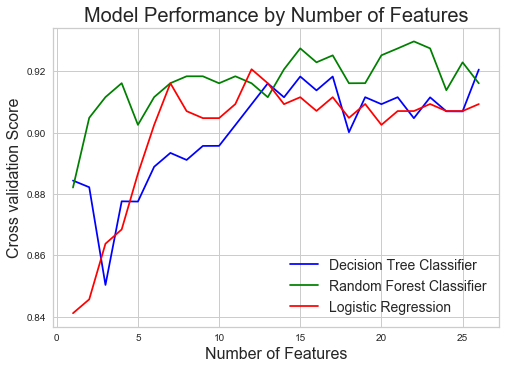

In [12]:
# Get optimal features for Decision Tree Classifier.
print('DTC Best number of features :', dtc.n_features_)
print('DTC Best features :', X.columns[dtc.support_],'\n')

# Get optimal features for Random Forest Classifier.
print('RFC Best number of features :', rfc.n_features_)
print('RFC Best features :', X.columns[rfc.support_],'\n')

# Get optimal features for Logistic Regression.
print('LR Best number of features :', lr.n_features_)
print('LR Best features :', X.columns[lr.support_])

# Plot RFECV results.
plt.plot(range(1, len(dtc.grid_scores_)+1), dtc.grid_scores_, c = 'Blue', label = 'Decision Tree Classifier')
plt.plot(range(1, len(rfc.grid_scores_)+1), rfc.grid_scores_, c = 'Green', label = 'Random Forest Classifier')
plt.plot(range(1, len(lr.grid_scores_)+1), lr.grid_scores_, c = 'Red', label = 'Logistic Regression')
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("Cross validation Score", fontsize=16)
plt.legend(fontsize=14)
plt.title("Model Performance by Number of Features", fontsize=20);

RFECV returns different combinations of variables each time it is run. This could maybe be run multiple times to see if there is a more consistent combination. Random Forest Classifier is consistently the most accurate here out of the three algorithms though, and it peaks as early as 10-14 features.

A Random Forest Classifer using a 10-feature combination of <b>['Age', 'MP', 'FGA', '3P', '2PA', 'FT', 'FTA', 'TRB', 'TOV', 'PTS']</b> returns the highest cross-validation score I have observed.

## <u>Milestone 3</u>

In [13]:
# Load 2021 data.

df_test = pd.read_csv(r'D:\School\550\Data\Final\Test\2021NBAPlayerStats.csv',encoding='latin1')
df_test = df_test[df_test.GS >= 41]  # Filter data to players who started at least half the season.

df_test = df_test.drop(['Rk','Player','Year','Tm'], axis=1)  # These are accounting variables and indices to remove.
df_test['Pos'] = [x.split('-')[0] for x in df_test['Pos']]  # Keep just the first value if there are multiple positions listed.


y_colt = ['AllStar']  # Variable that we want to predict.
x_colt = [i for i in df_test if i not in y_colt]  # Independent variables.
x_colt = [x for x in x_colt if x not in ['FG%','3P%','2P%','eFG%','TOV']]  # Remove those independent variables.


X_test = pd.get_dummies(df_test[x_colt])  # Creates columns for each of the five position values.
y_test = df_test[y_colt]  # Set y to df1['AllStar']


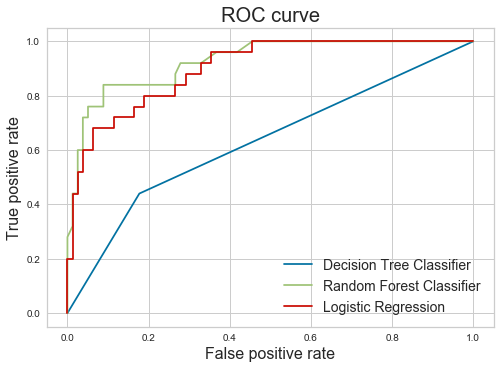

In [14]:
'''
Building ROC curves to examine the tradeoff in true and false positives. We can compare the area under curves to
provide another reference in choosing the best model for this task.
''' 

labels = ['Decision Tree Classifier','Random Forest Classifier','Logistic Regression']  # Labels for plot.
proba = [dtc.predict_proba(X_test)[:,1],
         rfc.predict_proba(X_test)[:,1],
         lr.predict_proba(X_test)[:,1]]
for n,i in zip(labels,proba):  # Loop through and plot ROC curves.
    fpr, tpr, thresholds = roc_curve(y_test, i)
    plt.plot(fpr, tpr, label = n)
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.legend(fontsize=14)
plt.title('ROC curve', fontsize=20);

These models were chosen because of the nature of the problem. We aim to predict NBA all-stars. This is a binary classification problem. Logistic Regression, Decision Tree, and Random Forest are among the most popular binary classification algorithms along with Naive Bayes, KNN, and SVM. From observing the RFECV and ROC curve results, it appears that using a Random Forest Classifier is the best choice out of these three models for predicting NBA all-stars based on the variables provided by this data.

## <u>Milestone 4</u>

In [15]:
# Look at log loss as an additional metric for the two models that returned probability outputs.
for n,i in zip(labels[1:],proba[1:]):
    print(n)
    print(log_loss(y_test,i),'\n')

Random Forest Classifier
0.288047759161076 

Logistic Regression
0.39499133629658617 



In [16]:
# Look at the confusion matrix and classification report for the Decision Tree Classifier.
print(labels[0])
print(confusion_matrix(y_test,proba[0]))
print(classification_report(y_test, proba[0]))

Decision Tree Classifier
[[65 14]
 [14 11]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        79
           1       0.44      0.44      0.44        25

    accuracy                           0.73       104
   macro avg       0.63      0.63      0.63       104
weighted avg       0.73      0.73      0.73       104

